In [27]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import plotnine as p9

from sklearn.linear_model import Lasso, LassoCV, lasso_path, enet_path, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/train_processed.csv')

In [4]:
# Normalize the features

feats = list(set(df.columns) - set(['logSalePrice', 'SalePrice']))
df_normalized = df.copy()
df_normalized[feats] = (df[feats] - df[feats].mean()) / df[feats].std()
# df_normalized['logSalePrice'] = df['logSalePrice']
df_normalized['SalePrice'] = df['SalePrice'] / 1000000  # convert the unit to millions

In [96]:
X = df_normalized[feats]
y = df_normalized['logSalePrice']

alphas = 10 ** np.arange(-3.5, 2, 0.01)

In [97]:
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, alphas=alphas)
alphas_enet, coefs_enet, _ = enet_path(
    X, y, l1_ratio=0.2,
    alphas=alphas)

In [98]:
alphas_ridge = 10 ** np.arange(-3.5, 2, 0.01)
clf = Ridge()
coefs_ridge = np.empty((X.shape[1], len(alphas_ridge)))
for i in range(len(alphas_ridge)):
    clf.set_params(alpha=alphas_ridge[i])
    clf.fit(X, y)
    coefs_ridge[:, i] = list(clf.coef_)

In [36]:
coefs_lasso.shape

(269, 150)

In [73]:
np.sum(np.abs(coefs_lasso[:, 0]))

0.2969166296159785

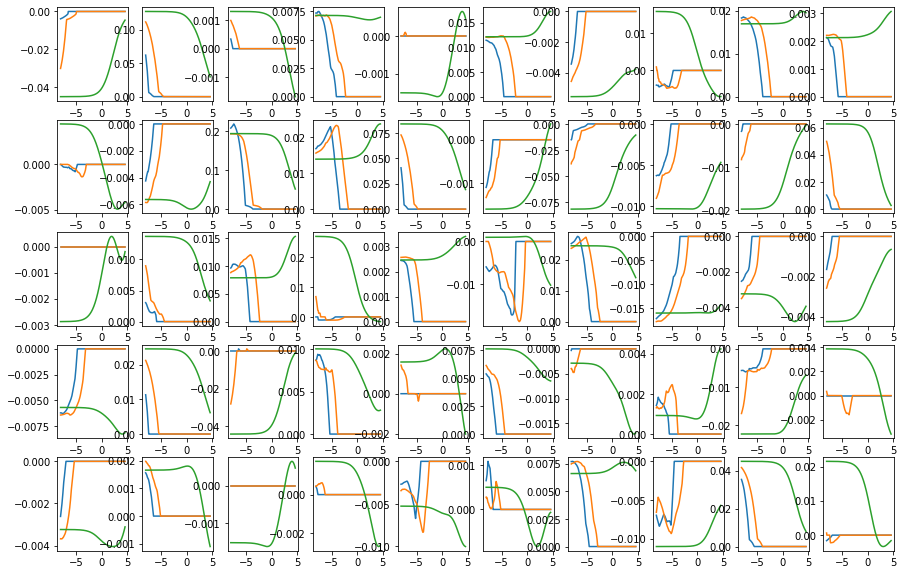

In [99]:
plt.figure(figsize=(15, 10))
for i in range(50):
    plt.subplot(5,10,i+1)
    var_id = i
    plt.plot(np.log(alphas_lasso), coefs_lasso[var_id, :])
    plt.plot(np.log(alphas_enet), coefs_enet[var_id, :])
    plt.plot(np.log(alphas_ridge), coefs_ridge[var_id, :])

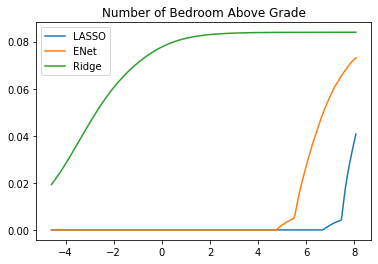

In [100]:
var_id = 14
plt.plot(-np.log(alphas_lasso), coefs_lasso[var_id, :], label='LASSO')
plt.plot(-np.log(alphas_enet), coefs_enet[var_id, :], label='ENet')
plt.plot(-np.log(alphas_ridge), coefs_ridge[var_id, :], label='Ridge')
plt.title('Number of Bedroom Above Grade')
plt.legend()

In [101]:
df.columns[32]

'HeatingQC_Po'

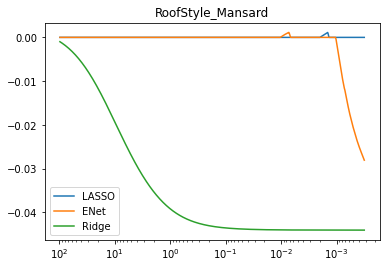

In [115]:
var_id = 32
plt.plot(alphas_lasso, coefs_lasso[var_id, :], label='LASSO')
plt.plot(alphas_enet, coefs_enet[var_id, :], label='ENet')
plt.plot(alphas_ridge, coefs_ridge[var_id, :], label='Ridge')
plt.title('RoofStyle_Mansard')
plt.gca().set_xscale('log')
plt.gca().invert_xaxis()
plt.legend()

0.03388441561391688

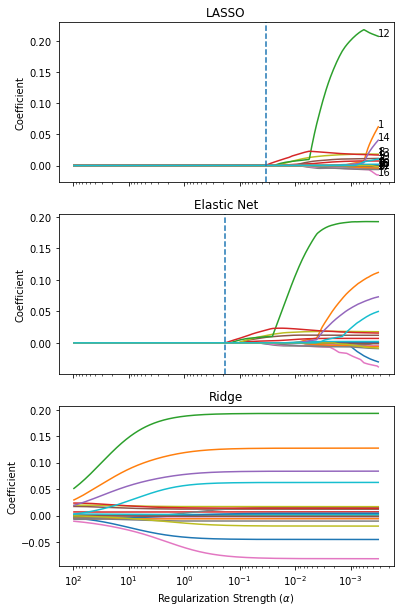

In [175]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for var_id in range(20):
    ax[0].plot(alphas_lasso, coefs_lasso[var_id, :])
    ax[0].text(alphas_lasso[-1], coefs_lasso[var_id, -1], str(var_id))
    ax[0].set_title('LASSO')
    
for var_id in range(20):
    ax[1].plot(alphas_enet, coefs_enet[var_id, :])
    ax[1].set_title('Elastic Net')

for var_id in range(20):
    ax[2].plot(alphas_ridge, coefs_ridge[var_id, :])
    ax[2].set_title('Ridge')

# Because x axis is shared, change one x axis will affect all subplots
ax[2].set_xscale('log')
ax[2].invert_xaxis()
ax[2].set_xlabel('Regularization Strength ($\\alpha$)')

for i in range(3):
    ax[i].set_ylabel('Coefficient')

# Add lines to show first non-zero coefficient
idx_1st_non_zero = np.where(coefs_lasso[0:20, :].sum(axis=0))[0][0]
alpha_1st_non_zero = alphas_lasso[idx_1st_non_zero]
ax[0].axvline(x=alpha_1st_non_zero, linestyle='--')

idx_1st_non_zero = np.where(coefs_enet[0:20, :].sum(axis=0))[0][0]
alpha_1st_non_zero = alphas_enet[idx_1st_non_zero]
ax[1].axvline(x=alpha_1st_non_zero, linestyle='--')

In [369]:
def plot_path_horizontal(
    var_id_list, feat_name, ylim=(0, 0.2), legend=True, figsize=(10,4)
):
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True,
                           figsize=figsize)
    # fig.suptitle('Feature Coefficient Path Comparison for Three Models')
    for var_id in var_id_list:
        ax[0].plot(alphas_lasso, coefs_lasso[var_id, :], label=feat_name[var_id])
        # ax[0].text(alphas_lasso[-1], coefs_lasso[var_id, -1], str(var_id))
        ax[0].set_title('LASSO')
        ax[0].set_ylim(ylim)

    for var_id in var_id_list:
        ax[1].plot(alphas_enet, coefs_enet[var_id, :], label=feat_name[var_id])
        ax[1].set_title('Elastic Net')
        ax[1].set_ylim(ylim)

    for var_id in var_id_list:
        ax[2].plot(alphas_ridge, coefs_ridge[var_id, :], label=feat_name[var_id])
        ax[2].set_title('Ridge')
        ax[2].set_ylim(ylim)

    # Because x axis is shared, change one x axis will affect all subplots
    ax[2].set_xscale('log')
    ax[2].invert_xaxis()
    
    # Set axis labels
    ax[0].set_ylabel('Coefficient')
    for i in range(3):
        ax[i].set_xlabel('Regularization Strength ($\\alpha$)')
        if legend:
            ax[i].legend()

    # Add lines to show first non-zero coefficient
    idx_1st_non_zero = np.where(coefs_lasso[var_id_list, :].sum(axis=0))[0][0]
    alpha_1st_non_zero = alphas_lasso[idx_1st_non_zero]
    ax[0].axvline(x=alpha_1st_non_zero, linestyle='--')

    idx_1st_non_zero = np.where(coefs_enet[var_id_list, :].sum(axis=0))[0][0]
    alpha_1st_non_zero = alphas_enet[idx_1st_non_zero]
    ax[1].axvline(x=alpha_1st_non_zero, linestyle='--')

In [370]:
def plot_path_vertical(
    var_id_list, feat_name, ylim=(0, 0.2), legend=True, figsize=(6, 10)
):
    
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=figsize)
    fig.suptitle('Feature Coefficient Path')
    for var_id in var_id_list:
        ax[0].plot(alphas_lasso, coefs_lasso[var_id, :], label=feat_name[var_id])
        # ax[0].text(alphas_lasso[-1], coefs_lasso[var_id, -1], str(var_id))
        ax[0].set_title('LASSO')
        ax[0].set_ylim(ylim)

    for var_id in var_id_list:
        ax[1].plot(alphas_enet, coefs_enet[var_id, :], label=feat_name[var_id])
        ax[1].set_title('Elastic Net')
        ax[1].set_ylim(ylim)

    for var_id in var_id_list:
        ax[2].plot(alphas_ridge, coefs_ridge[var_id, :], label=feat_name[var_id])
        ax[2].set_title('Ridge')
        ax[2].set_ylim(ylim)

    # Because x axis is shared, change one x axis will affect all subplots
    ax[2].set_xscale('log')
    ax[2].invert_xaxis()
    ax[2].set_xlabel('Regularization Strength ($\\alpha$)')

    for i in range(3):
        ax[i].set_ylabel('Coefficient')
        if legend:
            ax[i].legend()

    # Add lines to show first non-zero coefficient
    idx_1st_non_zero = np.where(coefs_lasso[var_id_list, :].sum(axis=0))[0][0]
    alpha_1st_non_zero = alphas_lasso[idx_1st_non_zero]
    ax[0].axvline(x=alpha_1st_non_zero, linestyle='--')

    idx_1st_non_zero = np.where(coefs_enet[var_id_list, :].sum(axis=0))[0][0]
    alpha_1st_non_zero = alphas_enet[idx_1st_non_zero]
    ax[1].axvline(x=alpha_1st_non_zero, linestyle='--')

In [373]:
np.corrcoef(df_normalized['GrLivArea'], df_normalized['1stFlrSF'])

array([[1.        , 0.56602397],
       [0.56602397, 1.        ]])

In [374]:
np.corrcoef(df_normalized['GrLivArea'], df_normalized['2ndFlrSF'])

array([[1.        , 0.68750106],
       [0.68750106, 1.        ]])

In [375]:
np.corrcoef(df_normalized['1stFlrSF'], df_normalized['2ndFlrSF'])

array([[ 1.        , -0.20264618],
       [-0.20264618,  1.        ]])

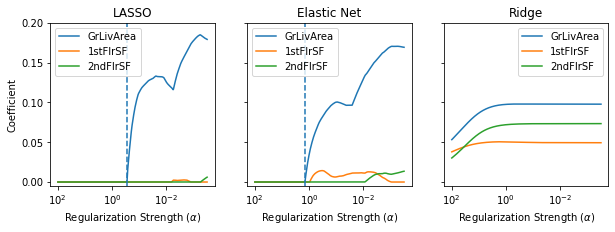

In [377]:
var_id_list = [129,250,238]
plot_path_horizontal(var_id_list, feats, figsize=(10,3), ylim=(-0.005, 0.2))

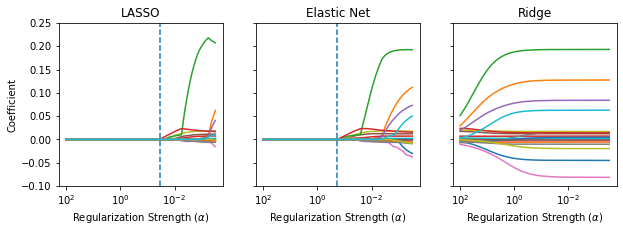

In [378]:
var_id_list = np.arange(20)
plot_path_horizontal(var_id_list, feats, figsize=(10,3), ylim=(-0.1, 0.25), legend=False)

In [287]:
[(i, X.columns[i])  for i in range(len(X.columns)) if 'Area' in X.columns[i]]

[(12, 'LotArea'),
 (98, 'GrLivArea*LotArea'),
 (129, 'GrLivArea'),
 (192, 'GarageArea'),
 (235, 'PoolArea'),
 (267, 'MasVnrArea')]

In [293]:
[(i, X.columns[i])  for i in range(len(X.columns)) if 'SF' in X.columns[i]]

[(39, 'BsmtFinSF_Not exist'),
 (60, 'BsmtFinSF_Rec'),
 (101, 'BsmtFinSF_BLQ'),
 (106, 'BsmtFinSF_Unf'),
 (114, 'TotalBsmtSF'),
 (126, 'LowQualFinSF'),
 (172, 'BsmtFinSF_LwQ'),
 (180, 'WoodDeckSF'),
 (187, 'BsmtUnfSF'),
 (201, 'OpenPorchSF'),
 (213, 'HouseStyle_SFoyer'),
 (238, '2ndFlrSF'),
 (245, 'BsmtFinSF_GLQ'),
 (250, '1stFlrSF'),
 (260, 'BsmtFinSF_ALQ')]

In [185]:
import seaborn as sns

<AxesSubplot:xlabel='BedroomAbvGr', ylabel='FullBath'>

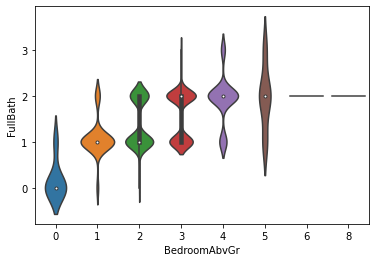

In [187]:
sns.violinplot(df['BedroomAbvGr'], df['FullBath'])

In [216]:
df_bed_bath = (
    df.groupby(['BedroomAbvGr', 'FullBath'])
    .apply(lambda x: len(x))
    .reset_index()
    .rename(columns={0: 'House_Count'})
#     .pivot(index='BedroomAbvGr', columns='FullBath')
)

In [254]:
np.corrcoef(df['BedroomAbvGr'], df['FullBath'])

array([[1.        , 0.36325198],
       [0.36325198, 1.        ]])

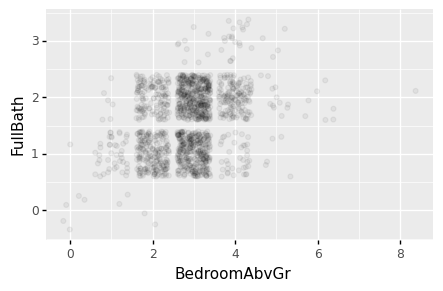

<ggplot: (8735180321512)>

In [248]:
(
    p9.ggplot(df, p9.aes('BedroomAbvGr', 'FullBath'))
    + p9.geom_jitter(alpha=0.05)
    # + p9.geom_density_2d()
    + p9.theme(figure_size=(5,3))
)

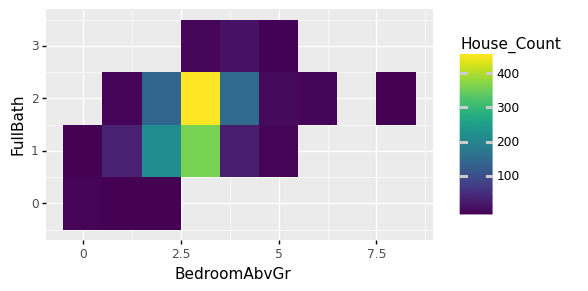

<ggplot: (8735182027141)>

In [237]:
(
    p9.ggplot(
        df_bed_bath,
        p9.aes('BedroomAbvGr', 'FullBath', fill='House_Count')
    )
    + p9.geom_tile()
    + p9.theme(figure_size=(5,3))
    # + p9.scale_fill_gradient(low='tab:lightred', high='red')
)

<AxesSubplot:xlabel='None-FullBath', ylabel='BedroomAbvGr'>

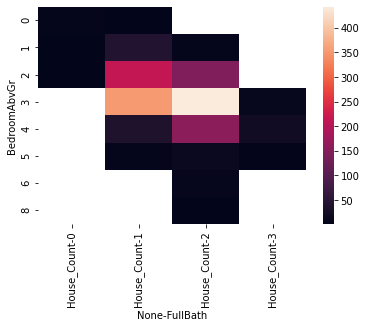

In [214]:
sns.heatmap(df_bed_bath)